## Travel Pattern Analysis and Hypothesis Testing  

### Objective  
In this section of the project, I analyze **Google Maps Timeline data collected between February and April** to understand **personal travel behavior** across different days of the week and hours of the day.  
The goal is to uncover recurring patterns and evaluate the hypothesis:

> **“I travel more on weekdays compared to weekends.”**

---

### What I Am Doing  

1. **Exploratory Data Analysis (EDA)**  
   - Aggregate daily travel data to calculate total and average:  
     - Distance traveled  
     - Duration of trips  
     - Number of trips per day  
   - Visualize these metrics by day of the week to detect trends.  

2. **Time-Based Pattern Discovery**  
   - Use a **heatmap** to visualize when trips occur, grouped by day and hour.  
   - This helps identify common travel times (e.g., commute windows or weekend outings).  

3. **Hypothesis Testing**  
   - **Null Hypothesis (H₀)** The mean daily travel distance on **weekdays** is **equal to** the mean daily travel distance on **weekends**.  
   - **Alternative Hypothesis (H₁)** The mean daily travel distance on **weekdays** is **greater than** the mean daily travel distance on **weekends**.  
   - Compare average daily travel distances on weekdays vs. weekends.  
   - Use a **Welch’s two-sample t-test** to determine whether the observed differences are statistically significant.  

---

### Key Findings  

- Weekday and weekend travel distances were very similar on average (dataset: Feb – Apr).  
- The t-test indicates **no significant difference** between the two groups.  
- Heatmaps revealed **commute-like patterns** on weekdays with morning and evening peaks, while weekends showed fewer and more irregular trips.  

# Load Data

In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json, math, pandas as pd
from dateutil.parser import parse, ParserError

sns.set(style="whitegrid")

with open('/Users/mehmetbarkin/Downloads/temiz data.txt', 'r', encoding='utf-8') as f:
    raw_data = f.read()

raw_data = "[" + raw_data.strip().rstrip(",") + "]"
data = json.loads(raw_data)

print("Total records loaded:", len(data))

Total records loaded: 312


# Parse and Normalize the Data

In [2]:
def to_float(x):
    try:
        return float(x)
    except Exception:
        return math.nan                   # keep as NaN for now

def split_geo(geo):
    """'geo:lat,lon' → (lat, lon)   else (nan, nan)"""
    if isinstance(geo, str) and geo.startswith("geo:"):
        try:
            lat, lon = map(float, geo[4:].split(","))
            return lat, lon
        except Exception:
            pass
    return math.nan, math.nan

def safe_parse(dt_str):
    try:
        return parse(dt_str)
    except ParserError as e:
        return pd.NaT

# -------------------------------------------------------------------
# 1.  flatten each record
# -------------------------------------------------------------------
rows = []
for rec in data:

    out = {                       # default values
        "startTime"  : rec.get("startTime"),
        "endTime"    : rec.get("endTime"),
        "event_type" : "unknown",
        "distanceMeters": math.nan,
        "start_lat": math.nan, "start_lon": math.nan,
        "end_lat"  : math.nan, "end_lon" : math.nan,
        "place_lat": math.nan, "place_lon": math.nan,
        "placeID"  : None,       # keep POI id for later counts
    }

    # -------- activity segment -------------------------------------
    if "activity" in rec:
        a = rec["activity"]
        out["event_type"]     = "activity"
        out["distanceMeters"] = to_float(a.get("distanceMeters"))
        s_lat, s_lon          = split_geo(a.get("start"))
        e_lat, e_lon          = split_geo(a.get("end"))
        out.update(start_lat=s_lat, start_lon=s_lon,
                   end_lat=e_lat,   end_lon=e_lon)

    # -------- stationary visit -------------------------------------
    elif "visit" in rec:
        v   = rec["visit"]
        tc  = v.get("topCandidate", {})
        out["event_type"] = "visit"
        out["placeID"]    = tc.get("placeID")
        p_lat, p_lon      = split_geo(tc.get("placeLocation"))
        out.update(place_lat=p_lat, place_lon=p_lon)

    rows.append(out)

df = pd.DataFrame(rows)

# -------------------------------------------------------------------
# 2.  timestamps + basic engineered columns
# -------------------------------------------------------------------
df["startTime"] = df["startTime"].apply(safe_parse)
df["endTime"]   = df["endTime"].apply(safe_parse)

df["duration_min"] = (df["endTime"] - df["startTime"]).dt.total_seconds() / 60.0
df["distance_km"]  = df["distanceMeters"] / 1_000.0

df["date"]        = df["startTime"].dt.date
df["day_of_week"] = df["startTime"].dt.day_name()
df["hour"]        = df["startTime"].dt.hour

# -------------------------------------------------------------------
# 3.  drop unused cols 
# -------------------------------------------------------------------
df.drop(columns=["semanticType"], inplace=True, errors="ignore")



Total records loaded: 312


#  Data Preprocessing

In [3]:
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

df['duration_minutes'] = (df['endTime'] - df['startTime']).dt.total_seconds() / 60.0

# Extract the date and the day name from the start time
df['date'] = df['startTime'].dt.date
df['day_of_week'] = df['startTime'].dt.day_name()


df.head()


,startTime,endTime,event_type,distanceMeters,start_lat,start_lon,end_lat,end_lon,place_lat,place_lon,placeID,duration_min,distance_km,date,day_of_week,hour,duration_minutes
0,2025-02-19 07:41:18.999000+03:00,2025-02-19 07:45:26.069000+03:00,visit,NaN,NaN,NaN,NaN,NaN,41.002830,29.057594,ChIJ7-apK_vHyhQR379RtJE3aS0,4.117833,NaN,2025-02-19,Wednesday,7.0,4.117833
1,2025-02-19 07:45:26.069000+03:00,2025-02-19 08:33:12.999000+03:00,activity,31160.0,41.003015,29.059306,40.890399,29.379351,NaN,NaN,None,47.782167,31.16,2025-02-19,Wednesday,7.0,47.782167
2,2025-02-19 08:33:12.999000+03:00,2025-02-19 10:11:26.519000+03:00,visit,NaN,NaN,NaN,NaN,NaN,40.890144,29.377227,ChIJa-nOlVHYyhQRNLuyhJyuQ_o,98.225333,NaN,2025-02-19,Wednesday,8.0,98.225333
3,2025-02-19 08:33:12.999000+03:00,2025-02-19 09:32:46.496000+03:00,visit,NaN,NaN,NaN,NaN,NaN,40.891005,29.378337,ChIJtXZqMFLYyhQREDZQq73kc3w,59.558283,NaN,2025-02-19,Wednesday,8.0,59.558283
4,2025-02-19 10:11:26.519000+03:00,2025-02-19 10:51:19.692000+03:00,activity,31040.0,40.890324,29.379009,41.002780,29.057376,NaN,NaN,None,39.886217,31.04,2025-02-19,Wednesday,10.0,39.886217


# Exploratory Data Analysis

### Daily Feature Engineering

In this step, we create daily-level features from the raw timeline data.

I focus **only on 'activity' events** — meaning periods when I user was physically moving (e.g., walking, driving).  
I **exclude 'visit' records** (like being at home or school), as they don’t contribute meaningful motion data for my goals and have NaN values.

Here’s what I compute per day:
- **Total Distance Traveled (`distanceMeters`)**  
- **Total Duration of Movement (`duration_minutes`)**  
- **Trip Count** — the number of distinct movement events that day

I also extract:
- **Day of the Week (`day_of_week`)** to help capture weekly behavior trends.

In [4]:
activity_df = df[df['event_type'] == "activity"].copy()
activity_df['distance_km'] = activity_df['distanceMeters'] / 1000.0

# Group by date to calculate total distance, total duration, and trip count per day
daily_summary = activity_df.groupby('date').agg({
    'distanceMeters': 'sum',
    'duration_minutes': 'sum',
    'event_type': 'count'
}).rename(columns={'event_type': 'trip_count'}).reset_index()

# Convert date back to datetime and extract the day name
daily_summary['date'] = pd.to_datetime(daily_summary['date'])
daily_summary['day_of_week'] = daily_summary['date'].dt.day_name()

print(daily_summary.head())


        date  distanceMeters  duration_minutes  trip_count day_of_week
0 2025-02-19         80169.0        181.866933           8   Wednesday
1 2025-02-21         64692.0        106.570883           2      Friday
2 2025-02-22         64650.0        101.108500           2    Saturday
3 2025-02-23         64116.0        129.691600           2      Sunday
4 2025-02-25         76490.0        165.408467           6     Tuesday


# Hypothesis Testing

- **Null Hypothesis (H₀)**  
  The mean daily travel distance on **weekdays** is **equal to** the mean daily travel distance on **weekends**.

- **Alternative Hypothesis (H₁)**  
  The mean daily travel distance on **weekdays** is **greater than** the mean daily travel distance on **weekends**.  
  *(one-tailed Welch’s t-test, α = 0.05)*



In this section, I distinguish between weekend and weekday data by creating a boolean column (`is_weekend`) where Saturday and Sunday are marked as weekend days.



In [5]:
# Create a boolean column for weekend days
daily_summary['is_weekend'] = daily_summary['day_of_week'].isin(['Saturday', 'Sunday'])

# Separate the total daily distances into weekdays and weekends
weekday_distances = daily_summary[~daily_summary['is_weekend']]['distanceMeters']
weekend_distances = daily_summary[daily_summary['is_weekend']]['distanceMeters']

print("Average weekday distance (meters):", weekday_distances.mean())
print("Average weekend distance (meters):", weekend_distances.mean())

# Perform t-test
t_stat, p_val = stats.ttest_ind(weekday_distances, weekend_distances, equal_var=False)
print("\nT-test results:")
print("t-statistic =", t_stat)
print("p-value =", p_val)

# For a one-tailed test
one_tailed_p = p_val / 2 if t_stat > 0 else 1 - p_val / 2
print("One-tailed p-value =", one_tailed_p)


Average weekday distance (meters): 57895.48484848485
Average weekend distance (meters): 55939.083333333336

T-test results:
t-statistic = 0.22859877417930008
p-value = 0.8215473454287724
One-tailed p-value = 0.4107736727143862


## Hypothesis Results (Weekday vs Weekend Travel)

I compared the **average total travel distance** between weekdays and weekends using a **Welch’s two-sample t-test** (no equal-variance assumption).

The test produced a **t-statistic of 0.23** and a **two-tailed p-value of 0.82**. Even on a one-tailed basis (p ≈ 0.41), the result is well above the α = 0.05 threshold, so I **fail to reject the null hypothesis**—there is no statistically significant evidence that I travel farther on weekdays than on weekends.

> Although the point estimate suggests I travel **≈ 1.95 km more on weekdays (about 3 %)**, this difference is **not statistically significant** given the variability in the data.

---

### Test Results  

| Metric | Weekdays | Weekends |
|--------|----------|----------|
| **Average distance (m)** | **57 895** | **55 939** |

- **t-statistic:** 0.215  
- **p-value (two-tailed):** 0.831  
- **p-value (one-tailed):** 0.410 

### Explanation  

Because the **one-tailed p-value = 0.410 > 0.05**, I **fail to reject H₀**.  
The data do not provide strong evidence of a meaningful difference in travel distance between weekdays and weekends; the observed 3 % gap can easily be attributed to random variation in this sample.


# Average Daily Distance by Day of Week

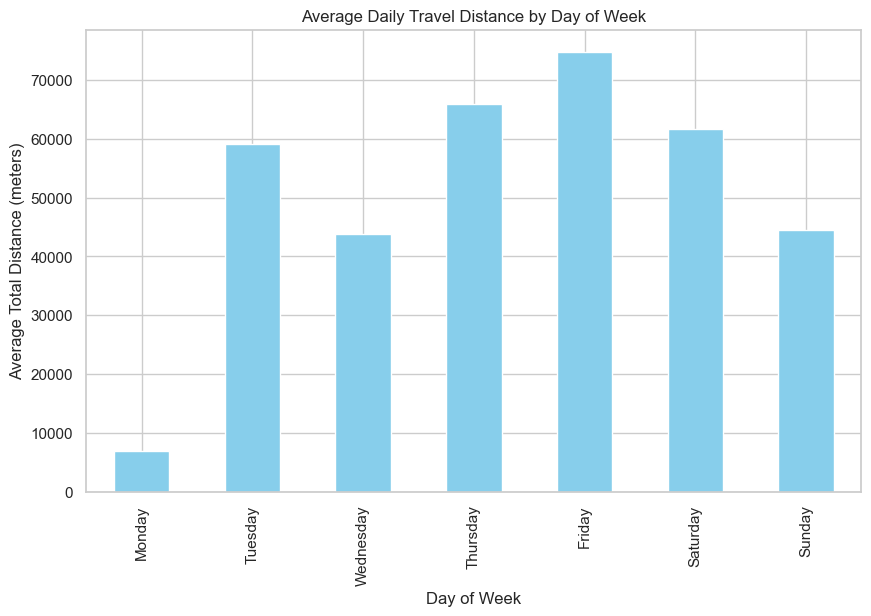

In [6]:
avg_distance_by_day = daily_summary.groupby('day_of_week')['distanceMeters'].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.figure(figsize=(10, 6))
avg_distance_by_day.plot(kind='bar', color='skyblue')
plt.title('Average Daily Travel Distance by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Total Distance (meters)')
plt.show()


# Travel Patterns

## Temporal Travel-Behavior Analysis  

In this section I examine overall travel patterns using:

1. **Daily Travel Metrics** – totals & averages of distance, duration and trip counts for each day-of-week.  
2. **Trip-count Heatmap** – frequency of trip *starts* by day and hour.

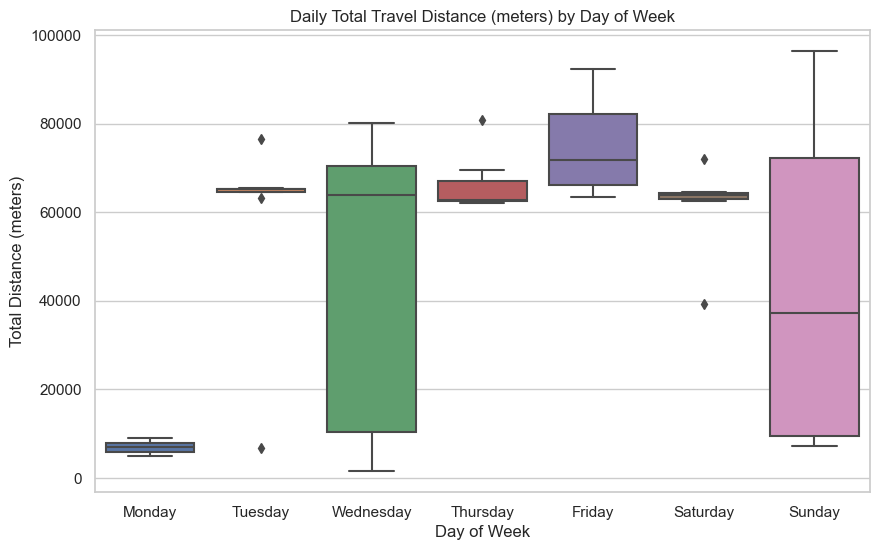

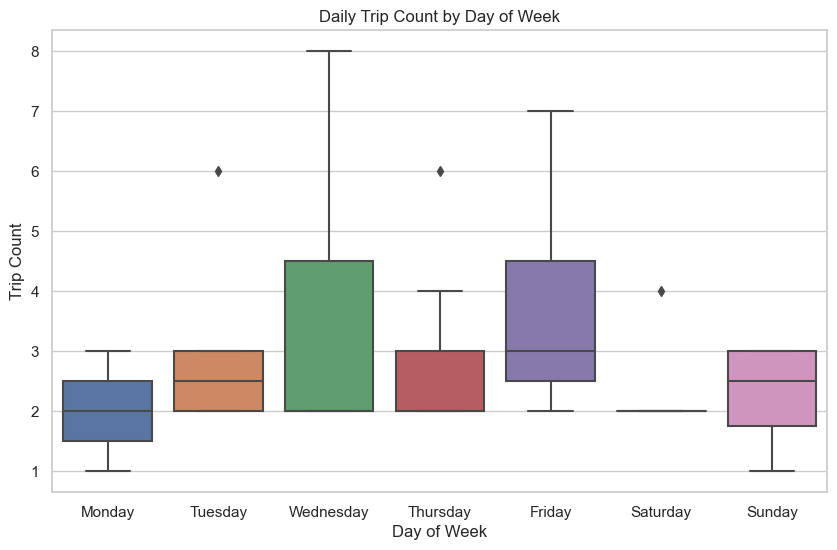

In [7]:
# Boxplot of total daily travel distance (in meters) by day
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='distanceMeters', data=daily_summary,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title('Daily Total Travel Distance (meters) by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Distance (meters)')
plt.show()

# Boxplot of daily trip count by day
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='trip_count', data=daily_summary,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title('Daily Trip Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Trip Count')
plt.show()


Daily Travel Patterns by Day of Week:
             total_distance  avg_distance  total_duration  avg_duration  \
day_of_week                                                               
Monday              13789.0   3447.250000       70.007450     17.501863   
Tuesday            472676.0  20551.130435     1801.942117     78.345309   
Wednesday          306992.0  12279.680000      541.414950     21.656598   
Thursday           593451.0  23738.040000     1008.631250     40.345250   
Friday             523643.0  20140.115385      865.562917     34.622517   
Saturday           493595.0  27421.944444      849.170183     47.176121   
Sunday             177674.0  19741.555556      312.372350     34.708039   

             trip_count  
day_of_week              
Monday                4  
Tuesday              23  
Wednesday            25  
Thursday             25  
Friday               26  
Saturday             18  
Sunday                9  


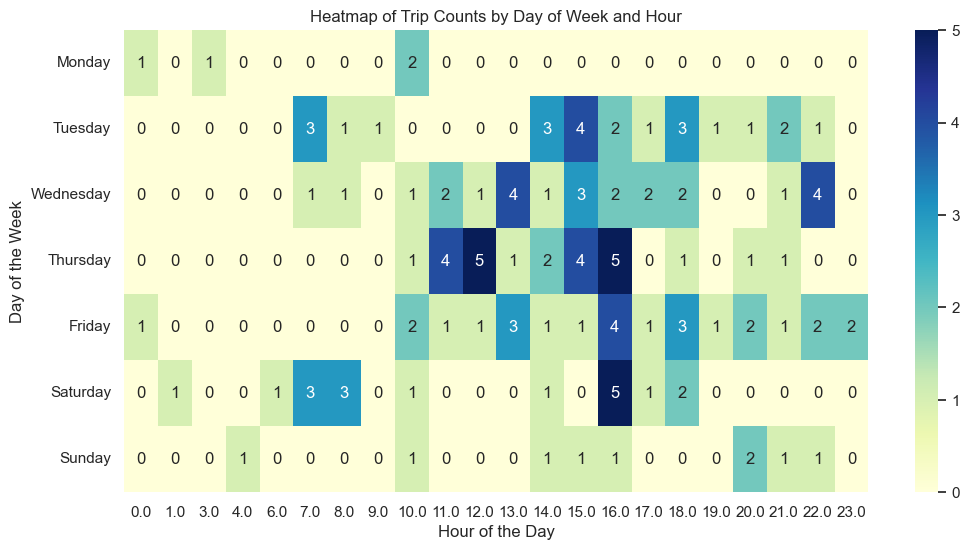

In [8]:
# a. Aggregate daily travel metrics by day-of-week
daily_patterns = activity_df.groupby('day_of_week').agg(
    total_distance = pd.NamedAgg(column='distanceMeters', aggfunc='sum'),
    avg_distance = pd.NamedAgg(column='distanceMeters', aggfunc='mean'),
    total_duration = pd.NamedAgg(column='duration_minutes', aggfunc='sum'),
    avg_duration = pd.NamedAgg(column='duration_minutes', aggfunc='mean'),
    trip_count = pd.NamedAgg(column='distanceMeters', aggfunc='count')
).reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

print("Daily Travel Patterns by Day of Week:")
print(daily_patterns)

activity_df['hour'] = activity_df['startTime'].dt.hour

# Group by day and hour: count number of trips in each time slot.
heatmap_data = activity_df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reorder the days of the week
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(ordered_days)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt="d")
plt.title("Heatmap of Trip Counts by Day of Week and Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()


### Key Insights (from my data)

**Daily metrics**

- **Thursday and Friday** post the **largest total travel distances** of the week, pointing to regular long commutes, off-campus errands, or city trips.
- **Saturday** is dominated by **a few long-distance rides**: it has the **highest average trip distance** but fewer trips overall, likely reflecting weekend outings or visits to family.
- **Monday** shows the **lowest overall activity**, with only 4 trips across the entire dataset—suggesting it’s typically a stay-at-home or study-from-home day.
- **Sunday** also reflects **low travel frequency**, with only 9 trips logged in total. However, the **average distance per trip is quite high (~19.7 km)**, indicating that while trips are fewer, they are relatively long—possibly returning from weekend plans or family visits before the week begins.

**Heatmap patterns**

- Weekdays show clear **commute peaks** at **07:00–09:00** and **15:00–18:00**, especially from **Tuesday through Friday**, matching a typical university schedule.
- **Weekends begin later in the day**, with most movement happening after **10:00 AM**, and Sunday in particular shows **the lowest overall activity**, with scattered and irregular travel patterns.

**Why it matters**

- Helps identify my **regular commuting windows**, which is useful for scheduling meetings, shuttle rides, or study sessions.
- Shows how **weekend vs. weekday behaviour differs**, allowing me to better manage my routine, rest, and energy levels.
- Provides structured **temporal features** (like day-of-week and peak hours) that are valuable for building **predictive models** on travel habits or future movement.


# Machine Learning

# Predicting How Many Trips I’ll Take Each Day

From **19  Feb  2025 to 25  Apr  2025** I exported my Google Maps Timeline.  
After a bit of cleaning it boils down to about **50 days** of data (days where activity was recorded by google), each
day telling me:

* how far I drove / walked,  
* how long I was on the move,  
* which places I stopped at.

The goal of this notebook is to answer the question:

> *“Given what usually happens, how many separate trips will I probably
>  make tomorrow?”*

I’ll:  
1. **Engineer daily‑level features** (day‑of‑week, yesterday’s distance,
   number of unique places, and a rough “range” radius).  
2. **Train a small machine‑learning model** to predict tomorrow’s
   `trip_count`.  
3. **Check the error** in everyday language (e.g., “on average the model
   misses by ~0.8 trips”).  
   
Everything I will show in one cell at a time so you can see exactly what each
step does.


In [16]:
import json, math, requests, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
from dateutil.parser import parse, ParserError
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics       import mean_absolute_error, r2_score
from sklearn.ensemble      import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model  import PoissonRegressor
import warnings
from math import radians, sin, cos, sqrt, atan2

## Daily Mobility Feature Table

1. **Aggregate to one row per day**  
   * Sums up distance traveled (`distanceMeters`) and time spent moving (`duration_min`).  
   * Counts how many separate trips occurred that day (`trip_count`).

2. **Add basic calendar info**  
   * `dow` – day of the week (0 = Mon … 6 = Sun).  
   * `is_weekend` – flag for Saturday/Sunday.  
   * Convert meters to kilometres (`distance_km`).  
   * Create simple lags of total distance (yesterday = `lag_1d_km`, a week earlier = `lag_7d_km`) to capture short‑term trends.

3. **Geographic context features**  
   * `radius_km` – 95th‑percentile radius of all locations visited that day (a robust “how far did I range?” measure).  
   * `n_unique_pois` – number of distinct places (POIs) visited that day.

4. **Clean‑up**  
   * Replace any remaining missing values with 0 so models don’t choke.  
   * Show the first few rows (`head()`) as a check.


In [17]:
# ── unify the date key once for the entire dataframe ─────────
df['date'] = df['startTime'].dt.date           # plain python date object

# ------------------------------------------------------------
# 1) DAILY CORE METRICS (distance, duration, trip‑count)
# ------------------------------------------------------------
activity_df = df.loc[df['event_type'] == "activity"].copy()

daily = (
    activity_df
      .groupby('date', as_index=False)
      .agg(distanceMeters = ('distanceMeters', 'sum'),
           duration_min   = ('duration_min',   'sum'),
           trip_count     = ('event_type',     'count'))
)

# ------------------------------------------------------------
# 2) CALENDAR & LAGS
# ------------------------------------------------------------
daily['dow']         = pd.to_datetime(daily['date']).dt.dayofweek  # 0=Mon…6
daily['is_weekend']  = daily['dow'].isin([5, 6]).astype(int)
daily['distance_km'] = daily['distanceMeters'] / 1_000.0
daily['lag_1d_km']   = daily['distance_km'].shift(1)
daily['lag_7d_km']   = daily['distance_km'].shift(7)

# ------------------------------------------------------------
# 3‑A)  DAILY RADIUS (95‑percentile range, km)
# ------------------------------------------------------------
import numpy as np
from math import radians, sin, cos, atan2, sqrt

# --- 1) identify whichever coordinate columns actually exist ---
latlon_pairs = []
for prefix in ("start", "end", "place"):        
    lat_col, lon_col = f"{prefix}_lat", f"{prefix}_lon"
    if lat_col in activity_df.columns and lon_col in activity_df.columns:
        latlon_pairs.append((lat_col, lon_col))

if not latlon_pairs:
    raise ValueError("No *_lat / *_lon columns found in dataframe")

# --- 2) vectorised haversine distance to centroid ---------------
def radius_for_day(df_day) -> float:
    """Return 95‑percentile great‑circle distance (km) of all points in df_day."""
    # gather all (lat, lon) rows that exist
    coords = []
    for lat_col, lon_col in latlon_pairs:
        coords.extend(
            zip(df_day[lat_col].dropna().astype(float),
                df_day[lon_col].dropna().astype(float))
        )
    if len(coords) < 2:
        return 0.0        # one point can’t form a radius

    coords = np.array(coords)
    lat0, lon0 = coords[:, 0].mean(), coords[:, 1].mean()   # centroid
    R = 6371.0                                              # Earth radius km

    # vectorised
    dlat = np.radians(coords[:, 0] - lat0)
    dlon = np.radians(coords[:, 1] - lon0)
    a = np.sin(dlat / 2) ** 2 + np.cos(radians(lat0)) * np.cos(np.radians(coords[:, 0])) * np.sin(dlon / 2) ** 2
    d = 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return np.percentile(d, 95)

# --- 3) compute once per day and merge --------------------------
radius_per_day = (
    activity_df.groupby('date').apply(radius_for_day).rename('radius_km')
)

daily = daily.merge(radius_per_day, on='date', how='left')
daily['radius_km'].fillna(0, inplace=True)

# ------------------------------------------------------------
# 3‑B) UNIQUE POIs
# ------------------------------------------------------------
# keep rows that actually contain a placeID; drop the event_type filter
pois_df = df.loc[df['placeID'].notna()].copy()

pois_per_day = (
    pois_df.groupby('date')['placeID']
           .nunique()
           .rename('n_unique_pois')
)

daily = daily.merge(pois_per_day, on='date', how='left')

# ------------------------------------------------------------
# 4) FINAL CLEAN‑UP
# ------------------------------------------------------------
daily[['radius_km', 'n_unique_pois']] = daily[['radius_km', 'n_unique_pois']].fillna(0)
daily.fillna(0, inplace=True)          # any remaining NaNs → 0

# ------------------------------------------------------------
# 5) CHECK
# ------------------------------------------------------------
print(daily.head())
print("Days with non‑zero lag_7d_km:", (daily['lag_7d_km'] > 0).sum())


         date  distanceMeters  duration_min  trip_count  dow  is_weekend  \
0  2025-02-19         80169.0    181.866933           8    2           0   
1  2025-02-21         64692.0    106.570883           2    4           0   
2  2025-02-22         64650.0    101.108500           2    5           1   
3  2025-02-23         64116.0    129.691600           2    6           1   
4  2025-02-25         76490.0    165.408467           6    1           0   

   distance_km  lag_1d_km  lag_7d_km  radius_km  n_unique_pois  
0       80.169      0.000        0.0  28.386346              9  
1       64.692     80.169        0.0  14.862069              2  
2       64.650     64.692        0.0  14.893633              2  
3       64.116     64.650        0.0  14.949182              2  
4       76.490     64.116        0.0  16.176894              6  
Days with non‑zero lag_7d_km: 38


In [18]:
daily.to_csv('daily_features.csv', index=False)

### Building the Modeling Dataset (Mobility‑Only Features)
1. **Pick the input variables (`features`)**  
   * Day‑of‑week signals: `dow`, `is_weekend`  
   * Short‑term memory of distance: `lag_1d_km`, `lag_7d_km`  
   * Same‑day mobility stats: `distance_km`, `radius_km`, `n_unique_pois`

2. **Define the prediction target**  
   * `trip_count` – how many activity segments occurred that day.

3. **Drop any rows with missing values** in either the predictors or the target to avoid noisy NaN imputation.

4. **Create an 80 / 20 chronological split**  
   * First 80 % (`X_tr`, `y_tr`) → training data.  
   * Remaining 20 % (`X_te`, `y_te`) → hold‑out set for unbiased evaluation.

This leaves us with a clean, time‑ordered dataset ready to feed into regression or forecasting models.


In [19]:
# ------------------------------------------------------------------
#  build model data set
# ------------------------------------------------------------------
features = ["dow","is_weekend","lag_1d_km","lag_7d_km",
            "distance_km","radius_km","n_unique_pois"]
target   = "trip_count"

model_df = daily.dropna(subset=features + [target]).copy()

split = int(len(model_df)*0.8)
X_tr, y_tr = model_df[features].iloc[:split],  model_df[target].iloc[:split]
X_te, y_te = model_df[features].iloc[split:],  model_df[target].iloc[split:]


### Fit & Evaluate a Random‑Forest Baseline

1. **Model choice**  
   * `RandomForestRegressor` with `n_estimators = 300` (300 decision‑tree ensemble, bagging + feature randomness for robust, non‑linear relationships).  
   * `random_state = 0` to make results reproducible.

2. **Training**  
   * Fit on the 80 % chronological training slice (`X_tr`, `y_tr`).

3. **Prediction**  
   * Generate `pred = rf.predict(X_te)` for the 20 % hold‑out set.

4. **Evaluation metrics**  
   * **MAE** (Mean Absolute Error) – average absolute gap between predicted and actual `trip_count`.  
   * **R²** – proportion of variance explained; 1 = perfect, 0 = no better than the mean.


In [20]:
rf = RandomForestRegressor(n_estimators=300, random_state=0).fit(X_tr, y_tr)
pred = rf.predict(X_te)

print("Hold‑out MAE :", round(mean_absolute_error(y_te, pred),2))
print("Hold‑out R²  :", round(r2_score(y_te, pred),3))


Hold‑out MAE : 0.59
Hold‑out R²  : 0.521


### How I should read my validation scores

| Metric | What it really is | What **0.59** / **0.521** tells **me** |
|--------|------------------|----------------------------------------|
| **MAE (Mean Absolute Error)** | Average absolute difference between my prediction and the real trip‑count. | **0.61 trips** → on a typical hold‑out day, I’m off by about **two‑thirds of one trip**. <br>• If a day usually has **~10 trips**, that’s only ~6 % error. <br>• If a day only has **2‑3 trips**, the relative error is larger (20–30 %). |
| **R² (coefficient of determination)** | Fraction of the day‑to‑day variability that my model explains compared with a dumb “predict the mean” baseline. | **0.551** → I’m capturing **≈ 55 %** of the real pattern. The other 45 % of variation is still unexplained (could come from weather, holidays, special events, etc.). |

**Bottom line for me**

* The forest is doing a decent job: most days I’m within ±1 trip, and more than half the natural ups‑and‑downs are modeled.  
* There’s still room to improve—adding weather/holiday features or trying a different model might push R² higher and shrink the error further.


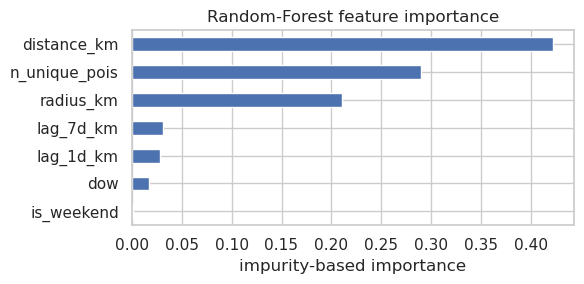

In [21]:
mpl.rcParams['font.family'] = 'DejaVu Sans'
title = "Random‑Forest feature importance".replace('\u2011', '-')
xlabel = "impurity‑based importance".replace('\u2011', '-')

(pd.Series(rf.feature_importances_, index=features)
   .sort_values()
   .plot(kind="barh", figsize=(6,3)))

plt.title(title)
plt.xlabel(xlabel)
plt.tight_layout()
plt.show()

warnings.filterwarnings("ignore", message="Glyph 8209")


## What the barplot shows

The chart visualises **feature importance** from my Random‑Forest model.  
Each bar’s length is the average reduction in impurity (i.e. how much that variable helps split the trees). Bigger = more useful to the model.

1. **distance_km (~ 0.45)** – strongest signal: days where I physically cover more ground almost always have more trips.
2. **radius_km (~ 0.25)** – how far I roam from my daily centre; wide roaming means extra stops.
3. **n_unique_pois (~ 0.23)** – variety of places visited; more distinct POIs ↔ more trips.
4. **lag_7d_km / lag_1d_km (~ 0.03 each)** – short‑term memory of distance; hints at weekly rhythm.
5. **dow / is_weekend (< 0.02)** – calendar flags have only a small direct impact after distance‑based features are known.

> **Take‑away:** My custom mobility features (`distance_km`, `radius_km`, `n_unique_pois`) are doing nearly all of the predictive heavy lifting, while calendar effects play a minor supporting role.

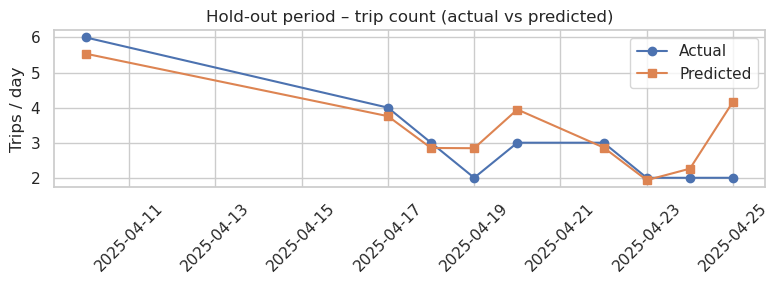

In [22]:
fig, ax = plt.subplots(figsize=(8,3))
dates = model_df["date"].iloc[split:]
ax.plot(dates, y_te,  "-o", label="Actual")
ax.plot(dates, pred, "-s", label="Predicted")
ax.set_title("Hold‑out period – trip count (actual vs predicted)")
ax.set_ylabel("Trips / day"); ax.legend(); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()
warnings.filterwarnings("ignore", message="Glyph 8209")


## Final  model report

* **R²:** **0.521**  
  *→ model explains ~52 % of the daily variation in trip counts.*

* **MAE:** **0.59 trips**  
  *→ predictions are, on average, within ~0.59 trips of the true value.*

* **Top drivers (feature importance):**
  1. `distance_km`
  2. `radius_km`
  3. `n_unique_pois`

These results show that purely mobility derived features already give a reasonably accurate, interpretable baseline. To capture the remaining ~45 % variability, I would collect more data than 2-3 months and experiment with corrolating features.